In [26]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.decomposition import PCA
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
clf = linear_model.Ridge(alpha=0.01)
linreg = linear_model.LinearRegression()
pca = PCA(n_components=1)

In [3]:
def find_dates(start, end, date_full):
    ind = np.logical_and((date_full - start) >= 0, (date_full - end) < 0)
    return ind

In [4]:
def get_data(root = 'z:/share/data/test_data/'):
    dates = pd.read_csv(root + './data/calendar.csv')
    hs300 = pd.read_csv(root + './data/000300_index.csv')
    zz500 = pd.read_csv(root + './data/000905_index.csv')
    st_stock = pd.read_csv(root + './data/st_stock.csv')
    all_stock = pd.read_csv(root + './data/summary.csv')
    
    stock_df = pd.DataFrame()
    for ticker in all_stock.symbol:
        if ticker in st_stock.symbol.values:
            continue
        stock_df_ = pd.read_csv('./data/' + ticker + '.csv')
        stock_df_['ticker'] = ticker
        stock_df = stock_df.append(stock_df_)

    stock_df = stock_df.reset_index().drop('index', axis = 1)
    stock_df = stock_df.drop('est_pb_fttm', axis = 1)
    
    return stock_df, hs300, zz500

In [42]:
stock_df.columns

Index(['adj_factor', 'close', 'date', 'est_pb_fttm', 'est_pb_fy0',
       'est_pb_fy1', 'est_pb_fy2', 'est_pb_fy3', 'est_pe_fttm', 'est_pe_fy0',
       'est_pe_fy1', 'est_pe_fy2', 'est_pe_fy3', 'high', 'low', 'market_value',
       'open', 'pb', 'pe', 'pe_ttm', 'preclose', 'status', 'ticker',
       'total_share', 'turnover', 'turnover_ratio', 'volume', 'vwap'],
      dtype='object')

In [48]:
stock_df.isna().sum() / len(stock_df)

adj_factor        0.000000
close             0.000000
date              0.000000
est_pb_fttm       1.000000
est_pb_fy0        0.014039
est_pb_fy1        0.351211
est_pb_fy2        0.350448
est_pb_fy3        0.357580
est_pe_fttm       0.271193
est_pe_fy0        0.063711
est_pe_fy1        0.272610
est_pe_fy2        0.262930
est_pe_fy3        0.256583
high              0.000000
low               0.000000
market_value      0.001095
open              0.000000
pb                0.003918
pe                0.054556
pe_ttm            0.090984
preclose          0.000000
status            0.000000
ticker            0.000000
total_share       0.001095
turnover          0.000000
turnover_ratio    0.001096
volume            0.000000
vwap              0.000000
dtype: float64

In [5]:
def select_stock(stock_is):
    stock_is['ret'] = stock_is.groupby('ticker')['close'].pct_change()
    stock_is = stock_is.replace([np.inf, -np.inf], np.nan)
    stock_is = stock_is.dropna()
    stock_is['fwd_ret'] = stock_is.groupby('ticker')['ret'].shift(-20)

    tickers = stock_is.groupby('ticker').tail(20)['ticker']
    x_ = stock_is.groupby('ticker').tail(20).drop(['ticker', 'date', 'fwd_ret'], axis = 1)
    x = stock_is.dropna().drop(['ticker', 'date', 'fwd_ret'], axis = 1)
        
    pca.fit(x.append(x_))
    x_pca = pca.fit_transform(x)
    clf.fit(x_pca, stock_is['fwd_ret'].dropna())
    x_pca_ = pca.fit_transform(x_)
        
    pred_ret = pd.concat([pd.Series(tickers.values), pd.Series(clf.predict(x_pca_))], axis = 1, ignore_index=True)
    pred_ret.columns = ['ticker', 'ret']
    pred_ret.ret += 1
        
    pred_ret_agg = pd.concat([pred_ret.drop('ret', axis = 1), pred_ret.groupby('ticker').agg('cumprod')], axis = 1)
    pred_ret_agg = pred_ret_agg.groupby('ticker').tail(1).sort_values('ret')
    tickers = pred_ret_agg.ticker[-100:].values
    return tickers

In [6]:
def get_beta(stock_is, hs300_is, zz500_is, tickers):
    stock_is['ret'] = stock_is.groupby('ticker')['close'].pct_change()
    stock_is = stock_is.replace([np.inf, -np.inf], np.nan)
    stock_is = stock_is.dropna()
        
    ret_is = stock_is.pivot(index = 'ticker', columns='date', values = 'ret').fillna(0)
    ret_is = ret_is.loc[ret_is.index.isin(tickers)]
    
    hs300_is['ret'] = hs300_is.close.pct_change()
    zz500_is['ret'] = zz500_is.close.pct_change()    
    hs300_is = hs300_is.set_index('date')
    zz500_is = zz500_is.set_index('date')
    ret_is = ret_is.append(hs300_is.ret)
    ret_is = ret_is.append(zz500_is.ret)
    ret_is = ret_is.replace([np.inf, -np.inf], np.nan)
    ret_is = ret_is.dropna(axis = 1)

    y = ret_is.iloc[:-2, :].mean().values
    x = ret_is.iloc[-2:, :].values
    linreg.fit(x.T, y)
    beta = linreg.coef_
    return beta

In [7]:
def pnl_calc(stock_oos, hs300_oos, zz500_oos, tickers, beta):
    stock_oos['ret'] = stock_oos.groupby('ticker')['close'].pct_change()
    stock_oos = stock_oos.replace([np.inf, -np.inf], np.nan)
    ret_oos = stock_oos.pivot(index = 'ticker', columns='date', values = 'ret').fillna(0)
    tickers_ = np.setdiff1d(tickers, ret_oos.index)
    for ticker_ in tickers_:
        ret_oos.loc[ticker_] = 0
        
    hs300_oos['ret'] = hs300_oos.close.pct_change()
    zz500_oos['ret'] = zz500_oos.close.pct_change()
    ret_mkt_oos = pd.concat([hs300_oos.ret, zz500_oos.ret], axis = 1)
    ret_mkt_oos = ret_mkt_oos.replace([np.inf, -np.inf], np.nan)
    ret_mkt_oos = ret_mkt_oos.fillna(0)
    
    ret_portfolio = ret_oos.mean().values
    ret_hedged = np.dot(ret_mkt_oos, beta)
    ret_ = ret_portfolio - ret_hedged
    return ret_

In [12]:
def back_test(years, stock_df, hs300, zz500):
    dates = np.array([])
    dates_all = np.array([])
    ret = np.array([])
    pos = pd.DataFrame(columns=np.append(['HS300', 'ZZ500'], stock_df.ticker.unique()))
    
    lookback = 12
    i = 0
    end = stock_df.date.max()
    
    for year in years:
        print('Doing Year', year)
        for month in range(1, 13):
            i += 1
            dates = np.append(dates, year * 1e4 + month * 1e2 + 1)

            if dates[-1] >= end:
                break

            if i <= lookback:
                continue

            is_start = dates[-lookback-1]
            is_end = dates[-1]
            oos_start = is_end
            oos_end = is_end + 31

            # get in-sample data
            stock_is = stock_df.loc[find_dates(is_start, is_end, stock_df.date)]
            hs300_is = hs300.loc[find_dates(is_start, is_end, hs300.date)]
            zz500_is = zz500.loc[find_dates(is_start, is_end, zz500.date)]

            # get out-of-sample data
            stock_oos = stock_df.loc[find_dates(oos_start, oos_end, stock_df.date)]
            hs300_oos = hs300.loc[find_dates(oos_start, oos_end, hs300.date)]
            zz500_oos = zz500.loc[find_dates(oos_start, oos_end, zz500.date)]

            # do stock selection
            tickers = select_stock(stock_is)

            # do beta calculation
            beta = get_beta(stock_is, hs300_is, zz500_is, tickers)

            # do oos back-testing
            ret_ = pnl_calc(stock_oos, hs300_oos, zz500_oos, tickers, beta)
            ret = np.append(ret, ret_)

            # document the positions
            pos.loc[int(dates[-1]), tickers] = 1
            pos.loc[int(dates[-1]), ['HS300', 'ZZ500']] = beta
            dates_all = np.append(dates_all, hs300_oos.date)
            
        if dates[-1] >= end:
            break            
    
    return pos, ret, dates_all

In [23]:
def plot_pnl(ret, dates):
    cumret = (ret + 1).cumprod()
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(dates, cumret)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cummulative Return')
    fig.savefig('pnl.png')

In [29]:
def get_dates(dates):
    dates_all = np.array([])
    for i in range(len(dates)):
        year = int(dates[i] / 10000)
        month = int(dates[i] / 100) % 100
        day = int(dates[i] % 100)
        dates_all = np.append(dates_all, datetime.date(year, month, day)) 
    return dates_all

In [47]:
def sharpe(ret):
    sharpe = ret.mean() / ret.std() * np.sqrt(252)
    return sharpe

def sortino(ret, thresh = 0):
    sortino = ret.mean() / ret[ret < thresh].std() * np.sqrt(252)
    return sortino

def mmd(ret):
    cumret = (ret + 1).cumprod()
    mmd = max(pd.Series(cumret).cummax() - cumret)
    return mmd

def sterling(ret):
    m = mmd(ret)
    sterling = ret.mean()/m
    return sterling

In [ ]:
years = range(2012, 2019)
# stock_df, hs300, zz500 = get_data()
hs300 = pd.read_csv('./data/000300_index.csv')
zz500 = pd.read_csv('./data/000905_index.csv')
stock_df = pd.read_csv('stock_df.csv', index_col = 0)
stock_df = stock_df.drop('est_pb_fttm', axis = 1)

In [13]:
pos, ret, dates = back_test(years, stock_df, hs300, zz500)

Doing Year 2012
Doing Year 2013
Doing Year 2014
Doing Year 2015
Doing Year 2016
Doing Year 2017


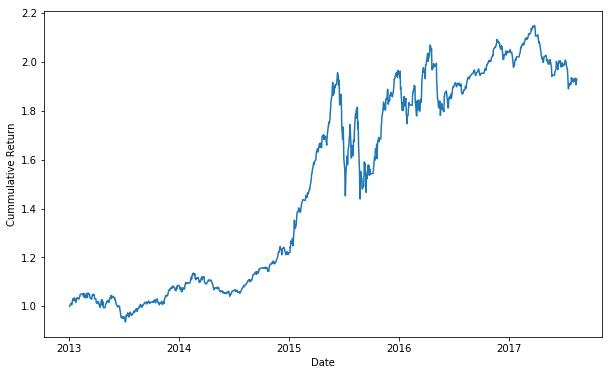

In [32]:
dates = get_dates(dates)
plot_pnl(ret, dates)

In [61]:
print('The average annual return is %.2f%%' %(ret.mean() * 252 * 100))
print('The average annual volatility is %.2f%%' %(ret.std() * np.sqrt(252) * 100))
print('The maximum drawdown is %.2f%%' % (mmd(ret) * 100))
print('The annualized Sharpe ratio is %.4f' % sharpe(ret))
print('The annualized Sortino ratio is %.4f' % sortino(ret))
print('The Sterling ratio is %.4f' % sterling(ret))

The average annual return is 16.19%
The average annual volatility is 16.73%
The maximum drawdown is 51.57%
The annualized Sharpe ratio is 0.9675
The annualized Sortino ratio is 1.0541
The Sterling ratio is 0.0012
